# Vertical mixing with analytic inputs

In this example, we look at turbulent mixing in 1D using an analytic diffusivity profile to drive particle movement. In so doing, we examine the ability of different numerical schemes to reproduce the Well Mixed Condition (WMC), which states that if a tracer is initially well-mixed it will remain so over time (Thomson, 1987). The example illustrates a problem that was identified in several models of turbulent mixing back in the late 1990s. As described by Visser (1997), the problem related to the inability of standard ("naive") random walk models to reproduce the WMC in spatially inhomogeneous diffusivity fields. Visser (1997) derived a formulation that corrected the problem, which later became widely used in particle tracking models for marine applications.

## Background theory

In 1D, and without advection, a standard ("naive") random walk model computes changes in particle positions using an equation of the form:

$$
\begin{equation}
    z_{n+1} = z_{n} +  \left(2 K \left(z, t \right)\right)^{1/2} \Delta W_{n} \qquad \text{Naive scheme,}
\end{equation}
$$

where $K$ is the vertical eddy diffusivity and $\Delta W$ is an incremental Wiener process that builds stochasticity into the model. While such a model works fine in spatially homogeneous diffusivity fields, it breaks in spatially inhomogeneous fields, as particles tend to accumulate in regions of low diffusivity. Grawe et al (2010) presented multiple numerical approximations, including that derived by Visser (1997), which correct for the artificial build up of particles in regions of low diffusivity through the inclusion of a deterministic drift term. Three of these have been implemented within PyLag. Without advection, and while taking the form of the diffusivity profile to be invariant with respect time, these are:

$$
\begin{equation}
    z_{n+1} = z_{n} +  \left(\dfrac{\partial K\left(z\right)}{\partial z}\right)\Delta t + \left(2 K\left(z\right)\right)^{1/2} \Delta W_n \qquad \text{Euler Scheme,}
\end{equation}
$$

$$
\begin{equation}
    z_{n+1} = z_{n} +  \left(\dfrac{\partial K\left(z\right)}{\partial z}\right)\Delta t + \left(2 K\left(\widetilde{z}\right)\right)^{1/2} \Delta W_n \qquad \text{Visser Scheme,}
\end{equation}
$$

$$
\begin{equation}
     z_{n+1} = z_{n} + \frac{1}{2} \frac{\partial K\left(z\right)}{\partial z} \left(\Delta W_{n}^{2} + \Delta t \right) + \left(2 K\left(z\right)\right)^{1/2} \Delta W_{n} \qquad \text{Milstein Scheme.}
\end{equation}
$$

The Euler and Visser schemes are identical, with the exception that in the Visser scheme, $K$ is evaluated at a position:

$$
\begin{equation}
     \widetilde{z} = z_{n} + \frac{\Delta t}{2} \frac{\partial K\left(z\right)}{\partial z}.
\end{equation}
$$

In the language of stochastic differential equations, a given appoximating process is said to converge in either a "strong" or a "weak" sense: strong convergence relates to how closely the approximating process reproduces sample paths; weak convergence to how closely some function of the value of the process is reproduced, for example, the mean particle position. The Euler and Visser schemes converge with order $\left(\Delta t\right)^{1/2}$ in the strong sense, and with order $\Delta t$ in the weak sense. In contrast, the Milstein scheme converges with order $\Delta t$ in both the strong and weak sense. Here we are insterested in the mean position of particles within the water column, meaning we are most interested in each scheme's convergence in the weak sense. Given this, we expect each approximation to perform equally well.

We will test this expectation below using the same diffusivity profile that Visser (1997) used. The diffusivity profile is given by the analytic experession:

$$
\begin{equation}
    k(z) = 0.001 + 0.0136245 z - 0.00263245 z^{2} + 2.11875 \times 10^{-4} z^{3} - \\
    8.65898 \times 10^{-6} z^{4} + 1.7623 \times 10^{-7} z^{5} - 1.40918 \times 10^{-9} z^{6}
\end{equation}
$$

where $k(z)$ is the vertical diffusivity as a function of depth, $z$. Depth is measured up from the sea floor ($z = 0$m) to the sea surface ($z = 40$m). A plot of the diffusivity profile is shown below. As in previous examples using analytic expressions, we encode the profile within an object of type `DataReader`, which allows it to be used with *Pylag* in the same way as any other `DataReader` object. In the following, we instantiate a new `DataReader` object and plot the analytic profile.

(0.0, 40.0)

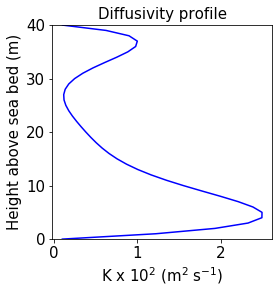

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.mock import MockVerticalDiffusivityDataReader
import pylag.random as random

from pylagtools.plot import create_figure

# Seed the PRNG
random.seed()

# Create data reader
data_reader = MockVerticalDiffusivityDataReader()

# Get z min and max. We give dummy values for the time and
# particle arguments, which in this example, aren't used to
# compute z_min or z_max.
z_min = data_reader.get_zmin_wrapper(0.0, ParticleSmartPtr())
z_max = data_reader.get_zmax_wrapper(0.0, ParticleSmartPtr())
n_z_levels = 41

# Reference heights above the sea bed
z_levels = np.linspace(z_min, z_max, n_z_levels, dtype=float)

# Generate the profile for plotting
Kh = np.empty_like(z_levels)
for i, z in enumerate(z_levels):
    Kh[i] = data_reader.get_vertical_eddy_diffusivity_analytic(z)

# Create figure for plotting
font_size = 15
fig, ax = create_figure(figure_size=(10., 10.), font_size=font_size)
    
# Plot the diffusivity profile
ax.plot(Kh*100., z_levels, 'b')
ax.set_title('Diffusivity profile', fontsize=font_size)
ax.set_xlabel(r'K x 10$^{2}$ (m$^{2}$ s$^{-1}$)', fontsize=font_size)
ax.set_ylabel('Height above sea bed (m)', fontsize=font_size)
ax.set_ylim(ymin=z_min, ymax=z_max)

The profile is designed to reflect observed diffusivity profiles found in stratified, shallow water environments, where the diffusivity is often high in the surface and bottom layers, and low in the middle of the water column.

We will evaluate the different schemes using the WMC. Brickman and Smith (2003) outlined an algorithm for demonstrating the WMC, which involves running an ensemble of $M$ model simulations, each involving $N_{p}$ particles, that are initially uniformly distributed in space. The same basic algorithm is followed here. Each simulation uses its own, random particle seed of $1000$ particles with initial $z$ positions uniformly distributed between the sea floor and the sea surface. Each simulation is run for 4 hrs using a time step of 6 s, and 5 simulations are run in total. At each time point, the concentration of particles is computed at $N_{z}$ (=41) equally spaced z-levels using an Epanechnikov Kernel Density Estimator (KDE) to compute particle concentrations. The time mean concentration $\overline{C(z)}$ at each depth level is then computed for each member of the ensemble. Finally, the ensemble mean concentration $\left\langle\overline{C(z)}\right\rangle$ is computed across the full ensemble. The WMC is said to be satisfied if the ensemble mean at each depth level lies within one standard deviation of the initial particle concentration.

## Running the particle tracking model

The experiment requires us to run an ensemble of simulations. Furthermore, we want to be able to do this using different numerical integration schemes. To make things a little cleaner, we will use a helper function that will run a single simulation and return particle positions over time.

In [2]:
from configparser import ConfigParser

from pylag.mock import MockOneDNumMethod


def run_particle_simulation(model_name):
    """Run a single simulation

    An initial particle seed is created. Particle starting depths are uniformly
    distributed over the vertical grid. Particle trajectories and final positions
    are then computed by integrating the model forward in time using the named
    iterative method.

    Parameters:
    -----------
    model_name: str
        Name of the iterative method under test

    Returns:
    --------
    particle_depths: ndarray[# particles, time]
       2D numpy array of particle depths
    """
    # Create a run config
    config = ConfigParser()
    
    # Specify that we are not restoring to a fixed depth
    config.add_section("SIMULATION")
    config.set("SIMULATION", "depth_restoring", "False")
    config.set("SIMULATION", "fixed_depth", "0.0")
    
    # Set the coordinate system, which here is a simple cartesian coordinate system
    config.add_section('OCEAN_CIRCULATION_MODEL')
    config.set('OCEAN_CIRCULATION_MODEL', 'coordinate_system', 'cartesian')
    
    # Specify the numerical scheme we will use
    config.add_section("NUMERICS")
    config.set("NUMERICS", "num_method", "standard")
    config.set("NUMERICS", "iterative_method", model_name)
    config.set("NUMERICS", "time_step_diff", str(time_step))

    # Use a reflecting vertical boundary condition
    config.add_section("BOUNDARY_CONDITIONS")
    config.set("BOUNDARY_CONDITIONS", "vert_bound_cond", "reflecting")

    # Create test object using the run config
    num_method = MockOneDNumMethod(config)

    # Initial z positions - uniformly distributed in the first instance
    z_positions = []
    for i in range(n_particles):
        z_positions.append(random.uniform(z_min, z_max))

    # Create array in which to store particle depths
    particle_depths = np.empty((n_times, n_particles), dtype=float)

    # Integrate the model forward in time
    for t_idx, t in enumerate(time):
        # Save z positions for the last time point
        particle_depths[t_idx, :] = z_positions[:]

        # Compute new z positions
        z_positions[:] = num_method.step(data_reader, t, z_positions)[:]

    return particle_depths

To speed things up a bit, we use an object of type MockOneDNumMethod to help manage the integration. While not strictly necessary, it cythonizes the particle loop, which yields a speed up over doing the same operation in python. Note the function references a time array, which we are yet to create. We set these below, then run ensemble simulations using different numerical approximation techniques. The data from each method are saved into separate arrays.

In [3]:
# Time variables (s)
time_start = 0.0
time_end = 3600.0*4
time_step = 6.0
time = np.arange(time_start, time_end, time_step)
n_times = time.shape[0]

# No. of particles to use in each simulation
n_particles = 1000

# No. of trials to use in each ensemble
n_trials = 5

# Store outputs in a dictionary
particle_data = {'Diff_Naive_1D': np.empty((n_trials, n_times, n_particles), dtype=float),
                 'Diff_Euler_1D': np.empty((n_trials, n_times, n_particles), dtype=float),
                 'Diff_Visser_1D': np.empty((n_trials, n_times, n_particles), dtype=float),
                 'Diff_Milstein_1D': np.empty((n_trials, n_times, n_particles), dtype=float)
                }

# Run the particle ensembles
for method, data in particle_data.items():
    for i in range(n_trials):
        data[i, :, :] = run_particle_simulation(method)[:,:]

## Visualising the result

We can quickly visualise the output using 2D histograms to highlight the position of particles throughout the water column and how these change with time. We do this for one of the trials for each method under test.

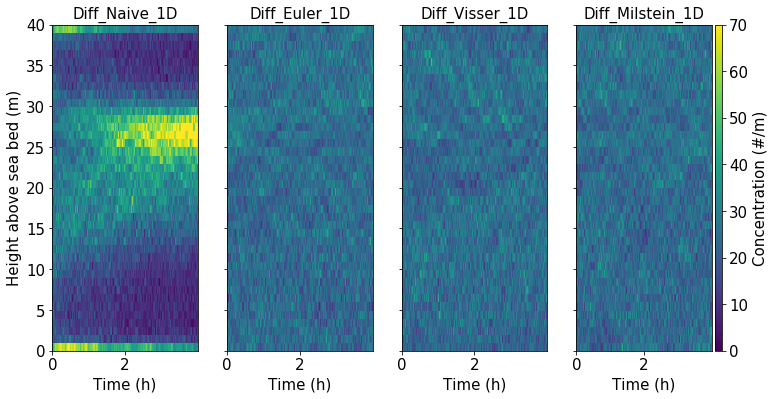

In [4]:
from pylagtools.plot import create_cbar_ax

# Grids for plotting using pcolormesh
bin_edges = range(int(z_max-z_min) + 1)
time_out = np.arange(time_start-time_step/2., time_end + time_step/2., time_step)/3600.0
depth_out = np.array(bin_edges)
time_grid, depth_grid = np.meshgrid(time_out, depth_out)

# Create figure
fig, axarr = plt.subplots(nrows=1,ncols=4, figsize=(12, 6), sharey=True)

# Store plots and calculated concentrations in lists
concentrations = []
plots = []

# Loop over each method and plot the concentration of particles
for i, (name, data) in enumerate(particle_data.items()):
    concentration = np.empty((len(bin_edges)-1, n_times))
    for j in range(n_times):
        hist, bins = np.histogram(data[0,j,:], bins=bin_edges)
        concentration[:,j] = hist
    concentrations.append(concentration)

    plot = axarr[i].pcolormesh(time_grid, depth_grid, concentration, vmin=0, vmax=70)
    plots.append(plot)
    
    axarr[i].set_title('{}'.format(name), fontsize=font_size)
    axarr[i].set_xlabel('Time (h)', fontsize=font_size)
    axarr[i].tick_params(axis='both', which='major', labelsize=font_size)
    axarr[i].tick_params(axis='both', which='minor', labelsize=font_size)
    
axarr[0].set_ylabel('Height above sea bed (m)', fontsize=font_size)

# Add colour bar to the last plot
cax = create_cbar_ax(axarr[3])
cbar = fig.colorbar(plots[3], cax=cax)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Concentration (#/m)', fontsize=font_size)


In the figure, the problems with the "naive" scheme become immediately apparent, with uneven particle concentrations throughout the water column. Comparing with the diffusivity profile above, it is clear particles have accumulated in regiond os low diffusivity, as explained by Visser (1997). In qualitative terms, the other three schemes exhibit a more even particle distribution.

We can quantitatively test whether each scheme satisfies the WMC in the following way.

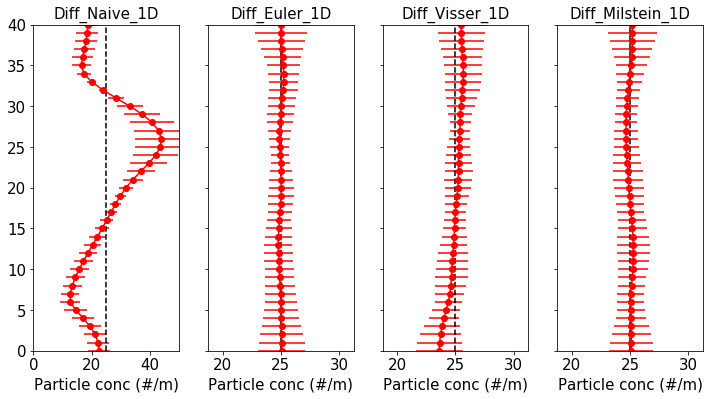

In [5]:
from pyqt_fit import kde, kde_methods, kernels

# Dictionary in which to store mean concentrations as a function of depth
means = {}

# Dictionary in which to store std's as a function of depth
stds = {}

# Compute KDE, means and std's for ...
#   - All methods
#   - All trials
#   - All time points
for i, (name, data) in enumerate(particle_data.items()):
    particle_kde = np.empty((n_trials, n_times, n_z_levels), dtype=float)
    for i in range(n_trials):
        for j in range(n_times):
            est = kde.KDE1D(data[i, j, :], lower=z_min, upper=z_max,
                    method=kde_methods.reflection, kernel=kernels.Epanechnikov())
            particle_kde[i, j, :] = n_particles * est(z_levels)

    means[name] = np.mean(particle_kde, axis=(0,1))
    stds[name] = np.std(particle_kde, axis=(0,1))

# Compute reference particle concentration (#/m)
ref_conc = n_particles/float(n_z_levels - 1)

# Create figure
fig, axarr = plt.subplots(nrows=1,ncols=4, figsize=(12, 6), sharey=True)

# Plot means and stds
for idx, name in enumerate(particle_data.keys()):
    axarr[idx].errorbar(means[name], z_levels, xerr=stds[name], fmt='-o', c='r')
    axarr[idx].axvline(ref_conc, ymin=0, ymax=1, c='k', linestyle='--')
    axarr[idx].set_title(name, fontsize=font_size)
    axarr[idx].set_xlabel('Particle conc (#/m)', fontsize=font_size)
    if name == 'Diff_Naive_1D':
        # Naive is known to fail so we set broarder xlims
        axarr[idx].set_xlim(xmin=0., xmax=2.*ref_conc)
    else:
        axarr[idx].set_xlim(xmin=ref_conc - ref_conc/4., xmax=ref_conc + ref_conc/4.)
    axarr[idx].set_ylim(ymin=z_min, ymax=z_max)

# Tidy up x and y tick labels
for ax in axarr:
    plt.setp(ax.get_xticklabels(), fontsize=font_size)
    plt.setp(ax.get_yticklabels(), fontsize=font_size)

In the figure, the vertical black dashed line marks the initial particle concentration, while in red is shown the mean particle concentration $\pm$ one standard deviation. The failure of the Naive scheme to satisfy the WMC can be clearly seen (note the different x-axis scale for the Naive scheme). Meanwhile, all the other schemes successfully pass the test for this particular analytic profile. 

## References


Brickman, D. and Smith, P. C., 2001. Lagrangian stochastic modeling in coastal oceanography. Journal of Atmospheric and Oceanic Technology, 19 (1), pp. 83-99

Grawe, U., 2010. Implementation of high-order particle-tracking schemes in a water column model. Ocean Modelling. 36(1-2) pp. 80-89

Thomson, D. J., 1987. Criteria for the selection of stochastic mod-els of particle trajectories in turbulent flows.J. Fluid Mech.,180, pp. 529–556

Visser, A. W., 1997. Using random walk models to simulate the vertical distribution of particles in a turbulent water column. Marine Ecology Progress Series, 158, pp. 275-281